## Compare  Non Zero Values Without Smoothing VS.  Non Zero Values With Smoothing

In [8]:
import pandas as pd 

noSmoothing = pd.read_csv("NonZeroNoSmoothing.csv")
withSmoothing = pd.read_csv("NonZeroWithSmoothing.csv")
noSmoothing_10e = pd.read_csv("NonZeroNoSmoothing_e-10.csv")
withSmoothing_10e = pd.read_csv("NonZeroWithSmoothing_e-10.csv")


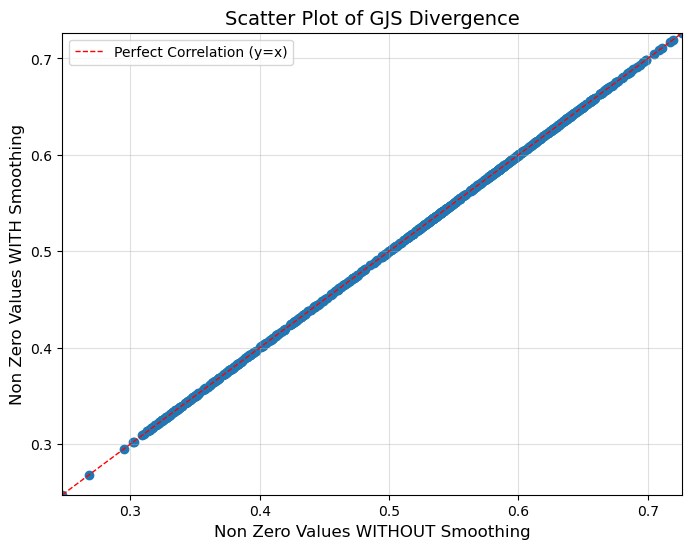

In [9]:
import matplotlib.pyplot as plt
import numpy as np

min_val = min(noSmoothing["SGJS Divergence"].min(), withSmoothing["SGJS Divergence"].min())
max_val = max(noSmoothing["SGJS Divergence"].max(), withSmoothing["SGJS Divergence"].max())

plt.figure(figsize=(8, 6)) 
plt.scatter(noSmoothing["SGJS Divergence"], withSmoothing["SGJS Divergence"]) 
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])

# Perfect Correlation Line
x = np.linspace(min_val, max_val, 100)
y = x
plt.plot(x, y, color='red', linestyle='dashed', linewidth=1, label='Perfect Correlation (y=x)')

plt.xlabel("Non Zero Values WITHOUT Smoothing", fontsize=12)
plt.ylabel("Non Zero Values WITH Smoothing", fontsize=12)
plt.title("Scatter Plot of GJS Divergence", fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.4) 

plt.show()



In [3]:
noSmoothing["SGJS Divergence"].compare(withSmoothing["SGJS Divergence"])

,self,other
0,0.563025,0.563024
1,0.603650,0.603649
2,0.570040,0.570039
3,0.518198,0.518197
4,0.607111,0.607110
...,...,...
835,0.569664,0.569663
836,0.532019,0.532018
837,0.622843,0.622842
838,0.631023,0.631022


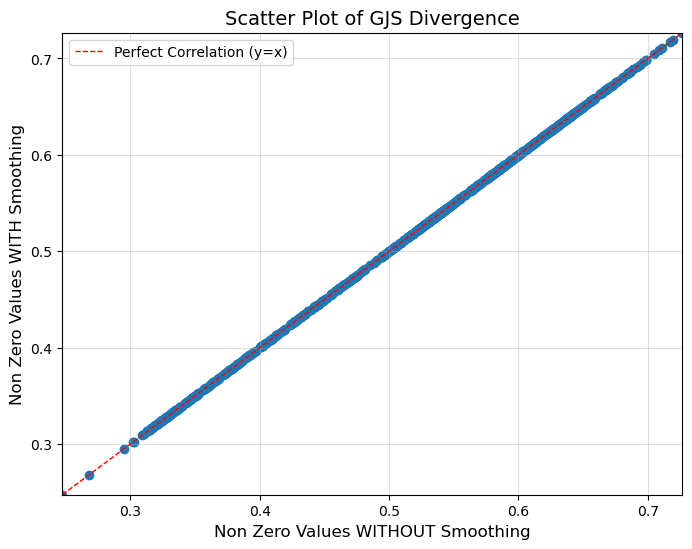

In [10]:
import matplotlib.pyplot as plt
import numpy as np

min_val = min(noSmoothing_10e["SGJS Divergence"].min(), withSmoothing_10e["SGJS Divergence"].min())
max_val = max(noSmoothing_10e["SGJS Divergence"].max(), withSmoothing_10e["SGJS Divergence"].max())

plt.figure(figsize=(8, 6)) 
plt.scatter(noSmoothing_10e["SGJS Divergence"], withSmoothing["SGJS Divergence"]) 
plt.xlim([min_val, max_val])
plt.ylim([min_val, max_val])

# Perfect Correlation Line
x = np.linspace(min_val, max_val, 100)
y = x
plt.plot(x, y, color='red', linestyle='dashed', linewidth=1, label='Perfect Correlation (y=x)')

plt.xlabel("Non Zero Values WITHOUT Smoothing", fontsize=12)
plt.ylabel("Non Zero Values WITH Smoothing", fontsize=12)
plt.title("Scatter Plot of GJS Divergence", fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.4) 

plt.show()



In [11]:
noSmoothing_10e["SGJS Divergence"].compare(withSmoothing_10e["SGJS Divergence"])

,self,other
0,0.563025,0.563025
1,0.603650,0.603650
2,0.570040,0.570040
3,0.518198,0.518198
4,0.607111,0.607111
...,...,...
835,0.569664,0.569664
836,0.532019,0.532019
837,0.622843,0.622843
838,0.631023,0.631023


## Only Non Zero  Values Without Smoothing

In [4]:
import pandas as pd
import numpy as np
import glob
import os
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, ks_2samp, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.special import kl_div

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='methylation_analysis_3.log', 
    filemode='w'                        
)

def calculate_divergences_and_ks(df, smoothing=1e-10):
    """Calculates normalized divergences (JSD, KL, GJS, SGJS) and KS test for methylation data.

    Args:
        df (pandas.DataFrame): DataFrame with 'methylated' and 'unmethylated' columns.
        smoothing (float, optional): Smoothing factor to add to counts. Defaults to 1e-10.

    Returns:
        tuple: Normalized divergences (JSD, KL, GJS, SGJS) and KS test statistic and p-value.
    """

    # Filter out rows with zero coverage
    df = df[df['coverage'] > 0].copy()

    # Drop rows where both methylated and unmethylated are zero 
    df = df[(df['methylated'] != 0) & (df['unmethylated'] != 0)].copy()

    #if len(df) == 0:
    #    return None, None, None, None, None, None
    
    #df["methylated"] += smoothing
    #df["unmethylated"] += smoothing
    
    # Calculate probabilities
    total = df["methylated"] + df["unmethylated"]
    p = df["methylated"] / total #+ smoothing
    q = df["unmethylated"] / total #+ smoothing
    
    # Divergence calculations (with normalizations)
    normalized_js_divergence = float(jensenshannon(p, q, base=2))  # JSD

    normalized_kl_divergence = float(entropy(p, q, base=2) - entropy(p, base=2))  # KLD

    # Geometric Jensen-Shannon Divergence
    normalized_gjs_divergence = float(np.sqrt(
        0.5 * (np.sqrt(entropy(p, q, base=2)) + np.sqrt(entropy(q, p, base=2)))
    ) / np.sqrt(np.log(2)))
    
    # Symmetric Geometric Jensen-Shannon Divergence
    m = (p + q) / 2
    normalized_sgjs_divergence = float( 0.5 * (
        np.sqrt(jensenshannon(p, m, base=2)) + np.sqrt(jensenshannon(q, m, base=2))
    ) / np.sqrt(np.log(2)))

    # Kolmogorov-Smirnov Test
    ks_statistic, ks_pvalue = ks_2samp(df["methylated"], df["unmethylated"])  # KST

    return normalized_js_divergence, normalized_kl_divergence, normalized_gjs_divergence, normalized_sgjs_divergence, ks_statistic, ks_pvalue

def read_bismark_file(filename):
    """Reads Bismark methylation data from a file."""
    column_names = ["chr", "start", "end", "coverage", "methylated", "unmethylated"]
    df = pd.read_csv(filename, sep='\t', header=None, names=column_names, compression='gzip')

    # Convert columns to correct data types
    df['start'] = pd.to_numeric(df['start'])
    df['end'] = pd.to_numeric(df['end'])
    df['coverage'] = pd.to_numeric(df['coverage'])
    df['methylated'] = pd.to_numeric(df['methylated'])
    df['unmethylated'] = pd.to_numeric(df['unmethylated'])

    return df

def clean_data(results_df):
    """Cleans the results DataFrame by removing file extensions from sample names."""
    results_df['Sample'] = results_df['Sample'].astype(str).str.replace('.bedgraph.gz', '', regex=False)
    return results_df


# Data processing pipeline
data_directory = "/home/eharpu/methylation_analysis/samples_testing"
results = []

# Get all sample subdirectories
sample_directories = [d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))]

# Iterate through files
for sample_dir in sample_directories:
    sample_path = os.path.join(data_directory, sample_dir)

    logging.info(f"Processing sample directory: {sample_path}")

    # Iterate through files in each sample directory
    for file_path in glob.glob(os.path.join(sample_path, "*_chr_*.cov.gz")):
        try:
            filename = os.path.basename(file_path)
            parts = filename.split("_")

            context_type = parts[0]
            sample_name = parts[1] + "_" + parts[2].split(".")[0] 
            chromosome = parts[-1].split(".")[0]

            #logging.info(f"Processing file: {filename}")



            df = read_bismark_file(file_path)
            divergences = calculate_divergences_and_ks(df)
    
            results.append(
                {
                    "Sample": sample_name,
                    "Chromosome": chromosome,
                    "Context": context_type,
                    "JS Divergence": divergences[0],  
                    "KL Divergence": divergences[1],
                    "GJS Divergence": divergences[2],
                    "SGJS Divergence": divergences[3],
                    "KS Statistic": divergences[4],
                    "KS P-value": divergences[5]
                }
            )
    
        except Exception as e:
            logging.error(f"Error processing file {filename}: {e}")

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Clean data
#results_df = clean_data(results_df)

# Save the results to a CSV file
results_df.to_csv("methylation_analysis_results_NonZeroNoSmoothing_e-10.csv", index=False)

## Only Non Zero Values With Smoothing

In [5]:
import pandas as pd
import numpy as np
import glob
import os
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy, ks_2samp, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.special import kl_div

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename='methylation_analysis_3.log', 
    filemode='w'                        
)

def calculate_divergences_and_ks(df, smoothing=1e-10):
    """Calculates normalized divergences (JSD, KL, GJS, SGJS) and KS test for methylation data.

    Args:
        df (pandas.DataFrame): DataFrame with 'methylated' and 'unmethylated' columns.
        smoothing (float, optional): Smoothing factor to add to counts. Defaults to 1e-10.

    Returns:
        tuple: Normalized divergences (JSD, KL, GJS, SGJS) and KS test statistic and p-value.
    """

    # Filter out rows with zero coverage
    df = df[df['coverage'] > 0].copy()

    # Drop rows where both methylated and unmethylated are zero 
    df = df[(df['methylated'] != 0) & (df['unmethylated'] != 0)].copy()

    #if len(df) == 0:
    #    return None, None, None, None, None, None
    
    df["methylated"] += smoothing
    df["unmethylated"] += smoothing
    
    # Calculate probabilities
    total = df["methylated"] + df["unmethylated"]
    p = df["methylated"] / total #+ smoothing
    q = df["unmethylated"] / total #+ smoothing
    
    # Divergence calculations (with normalizations)
    normalized_js_divergence = float(jensenshannon(p, q, base=2))  # JSD

    normalized_kl_divergence = float(entropy(p, q, base=2) - entropy(p, base=2))  # KLD

    # Geometric Jensen-Shannon Divergence
    normalized_gjs_divergence = float(np.sqrt(
        0.5 * (np.sqrt(entropy(p, q, base=2)) + np.sqrt(entropy(q, p, base=2)))
    ) / np.sqrt(np.log(2)))
    
    # Symmetric Geometric Jensen-Shannon Divergence
    m = (p + q) / 2
    normalized_sgjs_divergence = float( 0.5 * (
        np.sqrt(jensenshannon(p, m, base=2)) + np.sqrt(jensenshannon(q, m, base=2))
    ) / np.sqrt(np.log(2)))

    # Kolmogorov-Smirnov Test
    ks_statistic, ks_pvalue = ks_2samp(df["methylated"], df["unmethylated"])  # KST

    return normalized_js_divergence, normalized_kl_divergence, normalized_gjs_divergence, normalized_sgjs_divergence, ks_statistic, ks_pvalue

def read_bismark_file(filename):
    """Reads Bismark methylation data from a file."""
    column_names = ["chr", "start", "end", "coverage", "methylated", "unmethylated"]
    df = pd.read_csv(filename, sep='\t', header=None, names=column_names, compression='gzip')

    # Convert columns to correct data types
    df['start'] = pd.to_numeric(df['start'])
    df['end'] = pd.to_numeric(df['end'])
    df['coverage'] = pd.to_numeric(df['coverage'])
    df['methylated'] = pd.to_numeric(df['methylated'])
    df['unmethylated'] = pd.to_numeric(df['unmethylated'])

    return df

def clean_data(results_df):
    """Cleans the results DataFrame by removing file extensions from sample names."""
    results_df['Sample'] = results_df['Sample'].astype(str).str.replace('.bedgraph.gz', '', regex=False)
    return results_df


# Data processing pipeline
data_directory = "/home/eharpu/methylation_analysis/samples_testing"
results = []

# Get all sample subdirectories
sample_directories = [d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))]

# Iterate through files
for sample_dir in sample_directories:
    sample_path = os.path.join(data_directory, sample_dir)

    logging.info(f"Processing sample directory: {sample_path}")

    # Iterate through files in each sample directory
    for file_path in glob.glob(os.path.join(sample_path, "*_chr_*.cov.gz")):
        try:
            filename = os.path.basename(file_path)
            parts = filename.split("_")

            context_type = parts[0]
            sample_name = parts[1] + "_" + parts[2].split(".")[0] 
            chromosome = parts[-1].split(".")[0]

            #logging.info(f"Processing file: {filename}")


            df = read_bismark_file(file_path)
            divergences = calculate_divergences_and_ks(df)
    
            results.append(
                {
                    "Sample": sample_name,
                    "Chromosome": chromosome,
                    "Context": context_type,
                    "JS Divergence": divergences[0],  
                    "KL Divergence": divergences[1],
                    "GJS Divergence": divergences[2],
                    "SGJS Divergence": divergences[3],
                    "KS Statistic": divergences[4],
                    "KS P-value": divergences[5]
                }
            )
    
        except Exception as e:
            logging.error(f"Error processing file {filename}: {e}")

# Create a DataFrame from results
results_df = pd.DataFrame(results)

# Clean data
#results_df = clean_data(results_df)

# Save the results to a CSV file
results_df.to_csv("methylation_analysis_results_NonZeroWithSmoothing_e-10.csv", index=False)

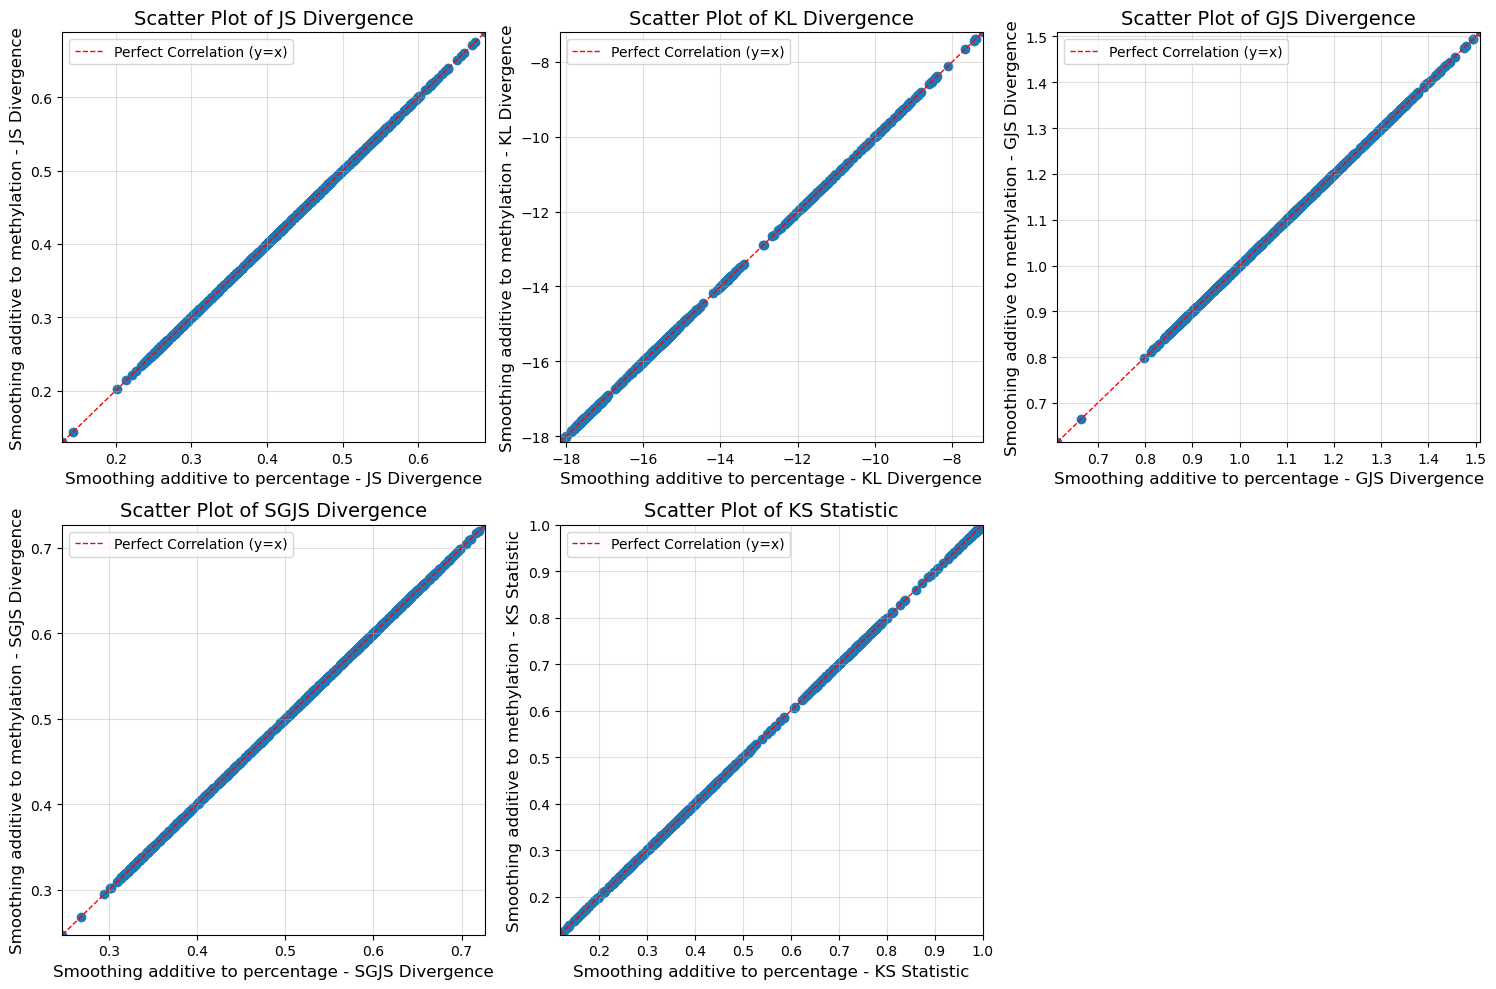

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


divergence_metrics = ["JS Divergence", "KL Divergence", "GJS Divergence", "SGJS Divergence", "KS Statistic"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  

for i, metric in enumerate(divergence_metrics):
    ax = axes[i] 

    min_val = noSmoothing_10e[metric].min()
    max_val = withSmoothing_10e[metric].max()

    ax.scatter(noSmoothing_10e[metric], noSmoothing_10e[metric])

    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.set_xlabel(f"Smoothing additive to percentage - {metric}", fontsize=12)
    ax.set_ylabel(f"Smoothing additive to methylation - {metric}", fontsize=12)
    ax.set_title(f"Scatter Plot of {metric}", fontsize=14)

    # Add perfect correlation line
    x = np.linspace(min_val, max_val, 100)
    ax.plot(x, x, color='red', linestyle='dashed', linewidth=1, label='Perfect Correlation (y=x)')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.4)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()


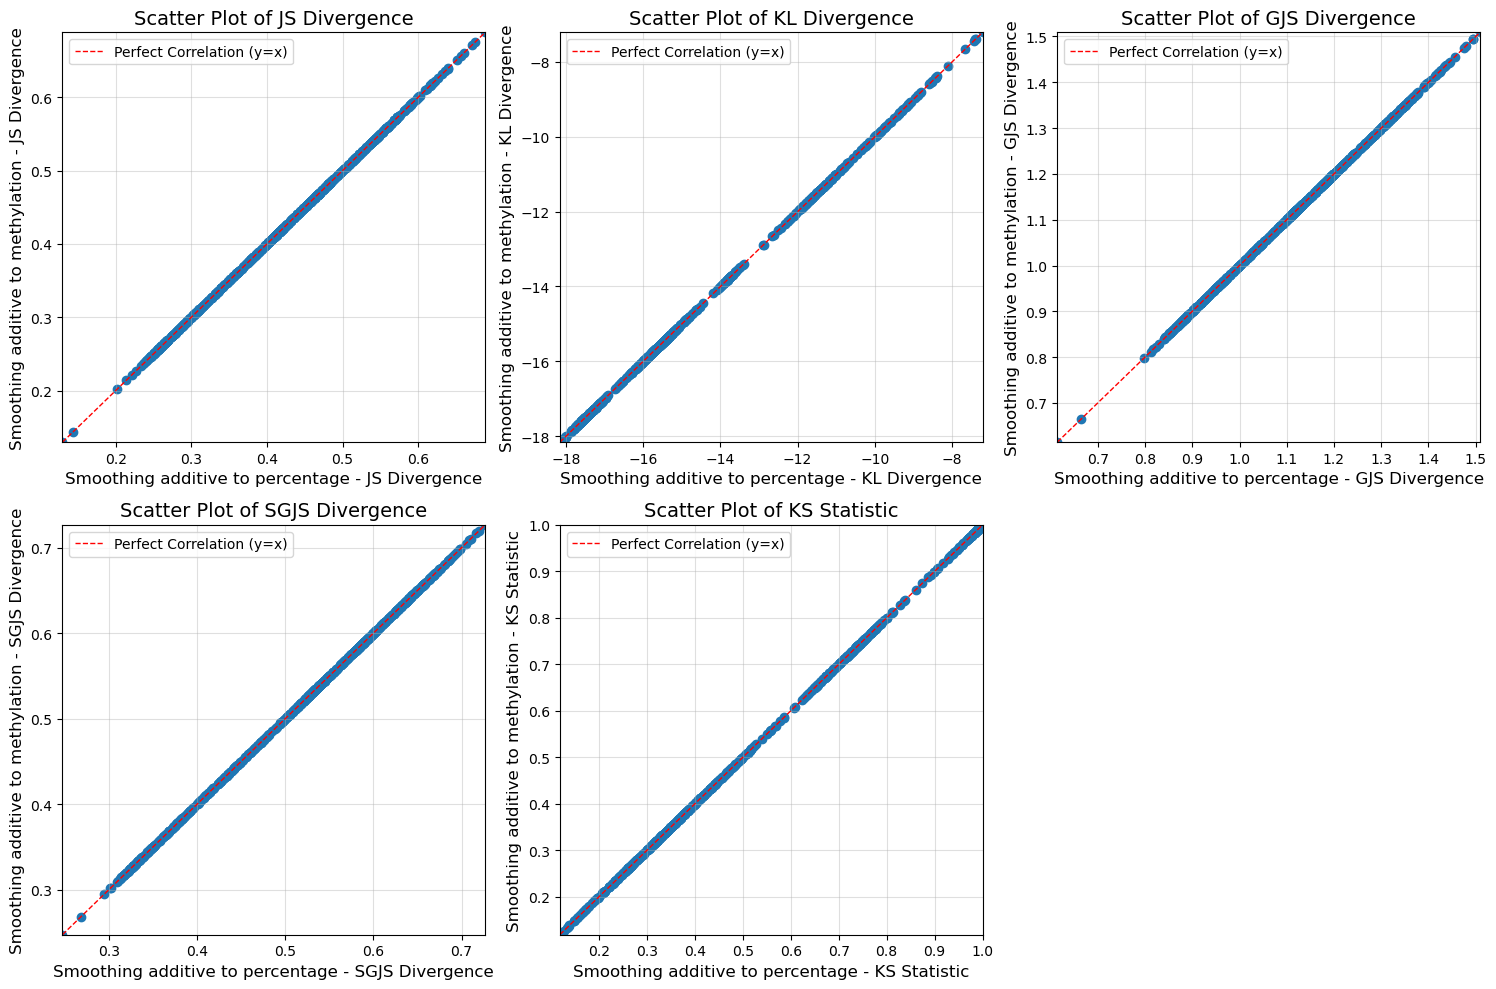

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


divergence_metrics = ["JS Divergence", "KL Divergence", "GJS Divergence", "SGJS Divergence", "KS Statistic"]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()  

for i, metric in enumerate(divergence_metrics):
    ax = axes[i] 

    min_val = noSmoothing[metric].min()
    max_val = withSmoothing[metric].max()

    ax.scatter(noSmoothing[metric], noSmoothing[metric])

    ax.set_xlim([min_val, max_val])
    ax.set_ylim([min_val, max_val])
    ax.set_xlabel(f"Smoothing additive to percentage - {metric}", fontsize=12)
    ax.set_ylabel(f"Smoothing additive to methylation - {metric}", fontsize=12)
    ax.set_title(f"Scatter Plot of {metric}", fontsize=14)

    # Add perfect correlation line
    x = np.linspace(min_val, max_val, 100)
    ax.plot(x, x, color='red', linestyle='dashed', linewidth=1, label='Perfect Correlation (y=x)')
    ax.legend(fontsize=10)
    ax.grid(alpha=0.4)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() 
plt.show()
